In [2]:
# built-in libraries
import sys
import math
import glob
import traceback

# keras
import keras
from keras import layers

# numpy
import numpy as np

# tensorflow
import tensorflow as tf

# matplotlib
from matplotlib import pyplot as plt

# sente
import sente
from sente import sgf

# tqdm
import tqdm

Metal device set to: Apple M1


2022-11-29 11:56:58.672679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-29 11:56:58.673924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Value-Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 19, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 192)       19392     
                                                                 
 batch_normalization (BatchN  (None, 19, 19, 192)      768       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 192)       331968    
                                                                 
 batch_normalization_1 (Batc  (None, 19, 19, 192)      768       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 192)     

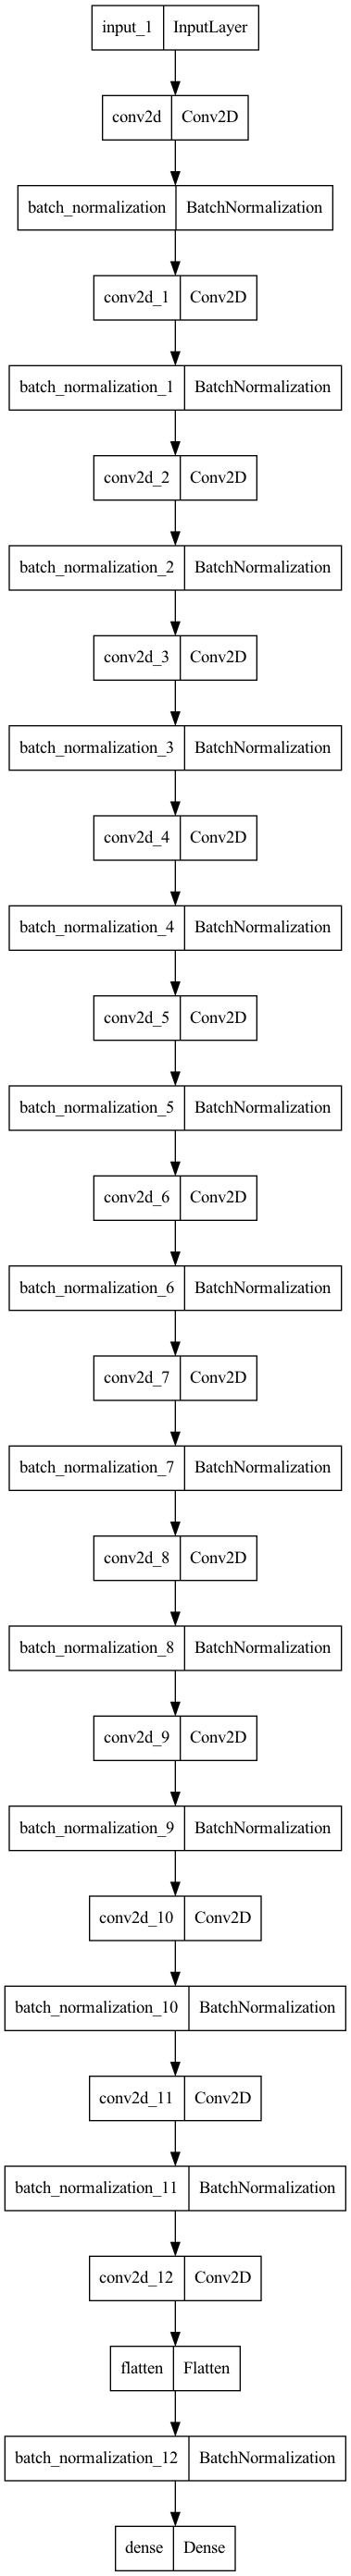

In [3]:
# get the numpy spec from a generic game
input_numpy = sente.Game().numpy()

# input layer
input_layer = layers.Input(shape=input_numpy.shape)
x = input_layer

# First layer has a kernel size of 5

x = layers.Conv2D(filters=192,
                  kernel_size=5,
                  padding="same",
                  activation="relu"
                  )(input_layer)
x = layers.BatchNormalization()(x)

# subsequent layers have kernel sizes of 3
for i in range(11):
    x = layers.Conv2D(filters=192,
                      kernel_size=3,
                      activation="relu",
                      padding="same")(x)
    x = layers.BatchNormalization()(x)

# output layer adds everything together with bias
x = layers.Conv2D(filters=1,
                  kernel_size=1,
                  activation="relu")(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=input_layer, outputs=output, name="Value-Network")
# keras.utils.plot_model(model)

model.summary()
keras.utils.plot_model(model, "Value-Network.png")

In [3]:
def sgf_generator(glob_string):
    """

    create an SGF file generator.

    :param glob_string: string to glob files with
    :return: a generator yielding
    """

    # obtain a generator for the glob
    files = glob.iglob(glob_string)

    for file in files:

        try:
            game = sgf.load(file)

            # if the board is not 19x19, skip
            if game.numpy().shape != (19, 19, 4):
                continue
            else:
                # yield the game
                yield game
        except (sente.exceptions.InvalidSGFException,
                ValueError) as error:
            traceback.print_exception(error, file=sys.stderr)
            continue

def get_8_fold_symmetries_x(game: sente.Game):
    """

    generates a numpy array containing a sente game, expanded to all of its 8-fold symmetries

    :param game: the game to get the symmetries for
    :return: 8x19x19x4 array containing all duplicates
    """

    board = game.numpy()
    transpose = np.transpose(board, axes=(1, 0, 2))
    x = np.empty((8,) + board.shape)

    x[0, :, :, :] = board
    x[1, :, :, :] = np.flip(board, axis=0)
    x[2, :, :, :] = np.flip(board, axis=1)
    x[3, :, :, :] = np.flip(board, axis=(0, 1))
    x[4, :, :, :] = transpose
    x[5, :, :, :] = np.flip(transpose, axis=0)
    x[6, :, :, :] = np.flip(transpose, axis=1)
    x[7, :, :, :] = np.flip(transpose, axis=(0, 1))

    return x

def get_8_fold_symmetries_y(move: np.array):
    """

    generates a numpy array containing a sente game, expanded to all of its 8-fold symmetries

    :param move:
    :param game: the game to get the symmetries for
    :return: 8x19x19x4 array containing all duplicates
    """

    transpose = np.transpose(move)
    x = np.empty((8,) + move.shape)

    x[0, :, :] = move
    x[1, :, :] = np.flip(move, axis=0)
    x[2, :, :] = np.flip(move, axis=1)
    x[3, :, :] = np.flip(move, axis=(0, 1))
    x[4, :, :] = transpose
    x[5, :, :] = np.flip(transpose, axis=0)
    x[6, :, :] = np.flip(transpose, axis=1)
    x[7, :, :] = np.flip(transpose, axis=(0, 1))

    return x

def training_data_generator(glob_string: str):
    """

    creates a training data generator object

    :return:
    """

    file_generator = sgf_generator(glob_string)

    for game in file_generator:

        player = game.get_winner()
        y = 1 if player == sente.stone.BLACK else 0

        # print("y =", y)

        for move in game.get_default_sequence():

            # break out of the loop as soon as we hit an illegal move
            if not game.is_legal(move):
                break

            """
            # otherwise, generate a label for the move
            move_array = np.zeros(shape=(19, 19))
            move_array[move.get_x(), move.get_y()] = 1
            """

            # get 8-fold symmetries of the board and the correct move

            x = get_8_fold_symmetries_x(game)
            """
            y = get_8_fold_symmetries_y(move_array)
            """
            # go through all the active games and fill the arrays
            for i in range(8):

                # yield the results
                yield x[i], (y,)

            # play the move on the board now
            game.play(move)

In [4]:
dataset = tf.data.Dataset.from_generator(lambda: training_data_generator("sgfs-uploaded/2021/*/*/*"),
                                             output_signature=(
                                                 tf.TensorSpec(shape=(19, 19, 4), dtype=tf.uint8),
                                                 tf.TensorSpec(shape=(1,))
                                             )).batch(32)

test_data = dataset.take(10000)
training_data = dataset.take(50000)

Fit the Model

In [5]:
# instantiate the generator
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy")

history = model.fit(training_data, epochs=5, validation_data=test_data)

Epoch 1/5


2022-11-25 11:02:10.048677: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-25 11:02:10.762987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "RU" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


     17/Unknown - 5s 185ms/step - loss: 0.8461

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "XM"
  game = sgf.load(file)


     41/Unknown - 9s 183ms/step - loss: 0.6182

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


    240/Unknown - 45s 183ms/step - loss: 0.7775

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


    463/Unknown - 85s 180ms/step - loss: 0.7540

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


    636/Unknown - 116s 180ms/step - loss: 0.7354

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "MULTIGOGM"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "AP" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


    708/Unknown - 128s 179ms/step - loss: 0.7196

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "LBC"
  game = sgf.load(file)


    776/Unknown - 140s 179ms/step - loss: 0.6719

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31637682-COMLv1-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "CA" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


   1449/Unknown - 262s 180ms/step - loss: 0.4319

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678808-None-None.sgf": Moves cannot be played in a node that already contains added stones


   1908/Unknown - 342s 179ms/step - loss: 0.3289

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678950-None-None.sgf": Moves cannot be played in a node that already contains added stones


   2220/Unknown - 398s 179ms/step - loss: 0.3565

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "XT"
  game = sgf.load(file)


   2352/Unknown - 422s 179ms/step - loss: 0.3840

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/05/31725167-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   3133/Unknown - 564s 180ms/step - loss: 0.3706

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/02/31624850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "SY"
  game = sgf.load(file)


   3307/Unknown - 597s 180ms/step - loss: 0.3679

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "FF" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "XX"
  game = sgf.load(file)


   3581/Unknown - 647s 180ms/step - loss: 0.3891

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/20/32159405-押野 篤-西鶴 睦希.sgf": The Property "CH" is not supported on this version of SGF (FF[4])


   3671/Unknown - 663s 180ms/step - loss: 0.3814

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "DTX"
  game = sgf.load(file)


   3922/Unknown - 709s 180ms/step - loss: 0.4088

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32116326-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32105634-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   4282/Unknown - 774s 180ms/step - loss: 0.4182

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32361392-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32364343-None-None.sgf": Missing Closing parentheses


   4324/Unknown - 782s 180ms/step - loss: 0.4166

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "SBKV"
  game = sgf.load(file)


   4574/Unknown - 827s 181ms/step - loss: 0.3991

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31892020-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907396-None-None.sgf": Missing Closing parentheses


   5006/Unknown - 906s 181ms/step - loss: 0.4212

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907230-None-None.sgf": Missing Closing parentheses


   5087/Unknown - 921s 181ms/step - loss: 0.4180

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907172-None-None.sgf": Missing Closing parentheses


   5279/Unknown - 957s 181ms/step - loss: 0.4057

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BYT"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BMT"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BBP"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BAG"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BAL"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WMT"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WBP"
  game = sgf.loa

   5345/Unknown - 969s 181ms/step - loss: 0.4009

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32417437-COSUMI-You.sgf": Missing Closing parentheses


   5755/Unknown - 1041s 181ms/step - loss: 0.3730

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32425601-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   5919/Unknown - 1070s 181ms/step - loss: 0.4008

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "KTV"
  game = sgf.load(file)


   6221/Unknown - 1126s 181ms/step - loss: 0.3873

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/16/32043513-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   6420/Unknown - 1162s 181ms/step - loss: 0.3994

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "ST" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


   6760/Unknown - 1225s 181ms/step - loss: 0.3983

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


   7851/Unknown - 1425s 181ms/step - loss: 0.4110

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079798-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   8083/Unknown - 1467s 181ms/step - loss: 0.4226

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32077219-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   8348/Unknown - 1516s 181ms/step - loss: 0.4272

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32063532-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   8534/Unknown - 1549s 181ms/step - loss: 0.4351

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32073228-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079797-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   8652/Unknown - 1571s 181ms/step - loss: 0.4350

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/10/31851212-None-None.sgf": Unable to find any SGF nodes in file


   9301/Unknown - 1689s 181ms/step - loss: 0.4175

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32122816-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   9417/Unknown - 1710s 181ms/step - loss: 0.4312

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32139612-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


   9947/Unknown - 1806s 181ms/step - loss: 0.4192

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337001-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  10053/Unknown - 1827s 182ms/step - loss: 0.4151

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32339665-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  10121/Unknown - 1839s 182ms/step - loss: 0.4288

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337053-None-None.sgf": Missing Closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32184508-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  10192/Unknown - 1852s 182ms/step - loss: 0.4293

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32191828-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  10265/Unknown - 1865s 182ms/step - loss: 0.4275

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "NN"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "OT" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32194175-None-None.sgf": Extra Closing Bracket


  10385/Unknown - 1886s 181ms/step - loss: 0.4230

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  11166/Unknown - 2295s 205ms/step - loss: 0.4274

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/09/31833100-None-None.sgf": Missing Closing parentheses


  11464/Unknown - 2487s 217ms/step - loss: 0.4235

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/31/32467491-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  11713/Unknown - 2544s 217ms/step - loss: 0.4278

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WAG"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WAL"
  game = sgf.load(file)


  12325/Unknown - 2835s 230ms/step - loss: 0.4250

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32445281-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  12603/Unknown - 3180s 252ms/step - loss: 0.4161

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32463986-COMLv5d-COMLv5d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  12871/Unknown - 3281s 255ms/step - loss: 0.4075

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "AP" is not supported on this version of SGF (FF[3])
The file was automatically converted to FF[4]
  game = sgf.load(file)


  13134/Unknown - 3626s 276ms/step - loss: 0.4124

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  13579/Unknown - 4301s 317ms/step - loss: 0.4036

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31576506-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31579189-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31574458-Player-COMLv2d.sgf": The Pro

  13871/Unknown - 4651s 335ms/step - loss: 0.4063

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "NS"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "TL"
  game = sgf.load(file)
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31575224-None-None.sgf": Missing Closing parentheses


  13934/Unknown - 4662s 334ms/step - loss: 0.4048

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31740611-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  14217/Unknown - 5005s 352ms/step - loss: 0.4161

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31737311-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  14872/Unknown - 5675s 382ms/step - loss: 0.4220

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/24/32281132-None-None.sgf": Missing Closing parentheses


  15815/Unknown - 5843s 369ms/step - loss: 0.4233

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32246234-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  15917/Unknown - 5861s 368ms/step - loss: 0.4236

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32248931-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  16672/Unknown - 5993s 359ms/step - loss: 0.4054

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32250963-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  17680/Unknown - 6170s 349ms/step - loss: 0.4178

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016216-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  17813/Unknown - 6195s 348ms/step - loss: 0.4150

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32018141-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  18341/Unknown - 6288s 343ms/step - loss: 0.4233

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016226-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  18901/Unknown - 6386s 338ms/step - loss: 0.4244

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31922227-COMLv8k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  18957/Unknown - 6396s 337ms/step - loss: 0.4252

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31939431-COMLv5-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  19420/Unknown - 6477s 333ms/step - loss: 0.4266

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31956506-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31949616-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  19487/Unknown - 6489s 333ms/step - loss: 0.4269

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31957541-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  19512/Unknown - 6493s 333ms/step - loss: 0.4267

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31945423-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  19655/Unknown - 6518s 332ms/step - loss: 0.4245

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31979875-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  19797/Unknown - 6543s 330ms/step - loss: 0.4288

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980543-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  20076/Unknown - 6592s 328ms/step - loss: 0.4243

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980851-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  20465/Unknown - 6661s 325ms/step - loss: 0.4230

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32219571-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  21210/Unknown - 6793s 320ms/step - loss: 0.4304

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32213904-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  21808/Unknown - 6907s 317ms/step - loss: 0.4270

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  21977/Unknown - 6937s 316ms/step - loss: 0.4238

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/25/32307198-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  22540/Unknown - 7037s 312ms/step - loss: 0.4252

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557605-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


  22614/Unknown - 7050s 312ms/step - loss: 0.4239

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32556515-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


  22733/Unknown - 7071s 311ms/step - loss: 0.4217

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557161-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557660-Player-COMLv11k.sgf": The Property "AP" is not supported on this version of SGF (FF[1])


  22923/Unknown - 7104s 310ms/step - loss: 0.4182

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557438-Player-COMLv11k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  22973/Unknown - 7113s 310ms/step - loss: 0.4174

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/04/32590979-COMLv5d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  23158/Unknown - 7146s 309ms/step - loss: 0.4200

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/05/32621576-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  23275/Unknown - 7166s 308ms/step - loss: 0.4180

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BC"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WC"
  game = sgf.load(file)


  23446/Unknown - 7197s 307ms/step - loss: 0.4216

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/02/32531897-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  23574/Unknown - 7219s 306ms/step - loss: 0.4234

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 21 only 9x9, 13x13 and 19x19 are currently supported


  24491/Unknown - 7380s 301ms/step - loss: 0.4276

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/20/33054440-None-None.sgf": Unable to find any SGF nodes in file


  24576/Unknown - 7395s 301ms/step - loss: 0.4272

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/18/33007769-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  24838/Unknown - 7441s 300ms/step - loss: 0.4231

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  26207/Unknown - 7685s 293ms/step - loss: 0.4279

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "OH"
  game = sgf.load(file)


  26745/Unknown - 7784s 291ms/step - loss: 0.4274

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  26768/Unknown - 7788s 291ms/step - loss: 0.4275

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/11/32792145-Player-COMLv9k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  28993/Unknown - 8178s 282ms/step - loss: 0.4086

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


  29052/Unknown - 8188s 282ms/step - loss: 0.4078

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


  29239/Unknown - 8220s 281ms/step - loss: 0.4052

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


  29551/Unknown - 8274s 280ms/step - loss: 0.4009

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


  29624/Unknown - 8286s 280ms/step - loss: 0.3999

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33275292-COMLv1k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  29626/Unknown - 8287s 280ms/step - loss: 0.3999

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33286184-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  29642/Unknown - 8290s 280ms/step - loss: 0.3997

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "ZT"
  game = sgf.load(file)


  30266/Unknown - 8397s 277ms/step - loss: 0.4038

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "KT"
  game = sgf.load(file)


  30718/Unknown - 8475s 276ms/step - loss: 0.4088

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "LZ"
  game = sgf.load(file)


  31926/Unknown - 8686s 272ms/step - loss: 0.4099

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029489-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  32113/Unknown - 8718s 271ms/step - loss: 0.4125

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029643-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  32707/Unknown - 8821s 270ms/step - loss: 0.4115

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "GaMe"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "SiZe"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "goWriteVersion"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "goWriteeXtension"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "GameName"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "DaTe"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF 

  33115/Unknown - 8891s 268ms/step - loss: 0.4120

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/26/33211777-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  33718/Unknown - 8995s 267ms/step - loss: 0.4170

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/21/33089837-COMLv3d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  34713/Unknown - 9166s 264ms/step - loss: 0.4168

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/07/32683842-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  35185/Unknown - 9247s 263ms/step - loss: 0.4188

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  36194/Unknown - 9421s 260ms/step - loss: 0.4198

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/30/33327657-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32700783-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  36260/Unknown - 9433s 260ms/step - loss: 0.4191

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718384-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  36428/Unknown - 9462s 260ms/step - loss: 0.4171

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719796-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  36591/Unknown - 9490s 259ms/step - loss: 0.4153

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718386-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719743-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  36658/Unknown - 9502s 259ms/step - loss: 0.4145

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "MU"
  game = sgf.load(file)


  36853/Unknown - 9536s 259ms/step - loss: 0.4123

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/01/32510219-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  37107/Unknown - 9580s 258ms/step - loss: 0.4095

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "JD"
  game = sgf.load(file)


  37393/Unknown - 9629s 257ms/step - loss: 0.4064

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32659675-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32663850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  38075/Unknown - 9747s 256ms/step - loss: 0.4102

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "GOWRITEFG"
  game = sgf.load(file)


  38217/Unknown - 9771s 256ms/step - loss: 0.4110

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WV"
  game = sgf.load(file)


  38686/Unknown - 9852s 255ms/step - loss: 0.4097

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32907744-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901544-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  39236/Unknown - 9947s 253ms/step - loss: 0.4063

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901545-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  39793/Unknown - 10048s 252ms/step - loss: 0.4065

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  40135/Unknown - 10109s 252ms/step - loss: 0.4031

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


  41041/Unknown - 10370s 253ms/step - loss: 0.3993

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/14/32887293-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  41332/Unknown - 10458s 253ms/step - loss: 0.3965

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 5 only 9x9, 13x13 and 19x19 are currently supported


  41856/Unknown - 10616s 254ms/step - loss: 0.3986

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  41912/Unknown - 10632s 254ms/step - loss: 0.3982

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "LB" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


  41914/Unknown - 10633s 254ms/step - loss: 0.3982

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: The Property "TR" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file)


  41915/Unknown - 10633s 254ms/step - loss: 0.3982

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181149-None-None.sgf": unmatched closing parentheses


  41918/Unknown - 10634s 254ms/step - loss: 0.3982

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181311-None-None.sgf": unmatched closing parentheses


  41928/Unknown - 10637s 254ms/step - loss: 0.3981

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181110-None-None.sgf": unmatched closing parentheses


  41939/Unknown - 10640s 254ms/step - loss: 0.3980

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181305-None-None.sgf": unmatched closing parentheses


  41943/Unknown - 10642s 254ms/step - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181123-None-None.sgf": unmatched closing parentheses


  41944/Unknown - 10642s 254ms/step - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181189-None-None.sgf": unmatched closing parentheses


  41948/Unknown - 10643s 254ms/step - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181296-None-None.sgf": unmatched closing parentheses


  42081/Unknown - 10683s 254ms/step - loss: 0.3966

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181150-None-None.sgf": unmatched closing parentheses


  42083/Unknown - 10684s 254ms/step - loss: 0.3966

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181283-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  42086/Unknown - 10685s 254ms/step - loss: 0.3966

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181214-None-None.sgf": unmatched closing parentheses


  42150/Unknown - 10704s 254ms/step - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181151-None-None.sgf": unmatched closing parentheses


  42154/Unknown - 10705s 254ms/step - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181274-None-None.sgf": unmatched closing parentheses


  42158/Unknown - 10706s 254ms/step - loss: 0.3959

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181152-None-None.sgf": unmatched closing parentheses


  42205/Unknown - 10720s 254ms/step - loss: 0.3955

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181111-None-None.sgf": unmatched closing parentheses


  42206/Unknown - 10720s 254ms/step - loss: 0.3955

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181106-None-None.sgf": unmatched closing parentheses


  42211/Unknown - 10722s 254ms/step - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181304-None-None.sgf": unmatched closing parentheses


  42212/Unknown - 10722s 254ms/step - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181161-None-None.sgf": unmatched closing parentheses


  42217/Unknown - 10724s 254ms/step - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181307-None-None.sgf": unmatched closing parentheses


  42219/Unknown - 10724s 254ms/step - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181314-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181171-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181230-None-None.sgf": unmatched closing parentheses


  42270/Unknown - 10740s 254ms/step - loss: 0.3949

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181289-None-None.sgf": unmatched closing parentheses


  42349/Unknown - 10763s 254ms/step - loss: 0.3942

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "BlackSpec"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "WhiteSpec"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "PlaCe"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "Size"
  game = sgf.load(file)


  43500/Unknown - 11118s 256ms/step - loss: 0.4005

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "CT"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "CM"
  game = sgf.load(file)


  44943/Unknown - 11573s 257ms/step - loss: 0.4046

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


  46732/Unknown - 12129s 260ms/step - loss: 0.4111

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33408742-None-None.sgf": Missing Closing parentheses


  47494/Unknown - 12358s 260ms/step - loss: 0.4158

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33420373-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  47655/Unknown - 12406s 260ms/step - loss: 0.4176

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "EVent"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "KoMi"
  game = sgf.load(file)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "SOurce"
  game = sgf.load(file)


  48217/Unknown - 12601s 261ms/step - loss: 0.4156

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439114-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  48369/Unknown - 12646s 261ms/step - loss: 0.4184

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439229-None-None.sgf": unmatched closing parentheses


  48410/Unknown - 12658s 261ms/step - loss: 0.4191

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  48632/Unknown - 12725s 262ms/step - loss: 0.4197

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  49707/Unknown - 13062s 263ms/step - loss: 0.4200

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


  49938/Unknown - 13132s 263ms/step - loss: 0.4181

/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py:16: Warning: Unknown SGF Property: "650,27,25,2,"web","https://gogameguru.com/i/2010/12/Maeda-Nobuaki-Kitani-Minoru.sgf","20160315134145",1996,"/_static/","
  game = sgf.load(file)
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/02/33381943-None-None.sgf": Missing Closing parentheses


  50000/Unknown - 13151s 263ms/step - loss: 0.4176

2022-11-25 14:41:21.589532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 

50000/50000 [==============================] - 14129s 283ms/step - loss: 0.4176 - val_loss: 1.3469
Epoch 2/5
   40/50000 [..............................] - ETA: 4:19:18 - loss: 9.6114e-04

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  239/50000 [..............................] - ETA: 4:10:04 - loss: 1.1313

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  462/50000 [..............................] - ETA: 4:09:49 - loss: 0.9776

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  775/50000 [..............................] - ETA: 4:17:57 - loss: 0.7577

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31637682-COMLv1-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 1449/50000 [..............................] - ETA: 4:08:53 - loss: 0.4738

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678808-None-None.sgf": Moves cannot be played in a node that already contains added stones


 1908/50000 [>.............................] - ETA: 3:41:03 - loss: 0.3600

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678950-None-None.sgf": Moves cannot be played in a node that already contains added stones


 2352/50000 [>.............................] - ETA: 3:24:01 - loss: 0.4262

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/05/31725167-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3133/50000 [>.............................] - ETA: 3:04:47 - loss: 0.3927

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/02/31624850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3581/50000 [=>............................] - ETA: 2:57:05 - loss: 0.4095

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/20/32159405-押野 篤-西鶴 睦希.sgf": The Property "CH" is not supported on this version of SGF (FF[4])


 3922/50000 [=>............................] - ETA: 2:52:13 - loss: 0.4324

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32116326-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32105634-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 4282/50000 [=>............................] - ETA: 2:47:44 - loss: 0.4369

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32361392-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32364343-None-None.sgf": Missing Closing parentheses


 4574/50000 [=>............................] - ETA: 2:44:30 - loss: 0.4100

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31892020-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907396-None-None.sgf": Missing Closing parentheses


 5006/50000 [==>...........................] - ETA: 2:40:12 - loss: 0.4312

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907230-None-None.sgf": Missing Closing parentheses


 5087/50000 [==>...........................] - ETA: 2:39:27 - loss: 0.4290

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907172-None-None.sgf": Missing Closing parentheses


 5345/50000 [==>...........................] - ETA: 2:37:11 - loss: 0.4096

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32417437-COSUMI-You.sgf": Missing Closing parentheses


 5755/50000 [==>...........................] - ETA: 2:33:52 - loss: 0.3810

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32425601-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6221/50000 [==>...........................] - ETA: 2:30:25 - loss: 0.3842

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/16/32043513-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6760/50000 [===>..........................] - ETA: 2:26:47 - loss: 0.3881

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


 7851/50000 [===>..........................] - ETA: 2:20:11 - loss: 0.3947

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079798-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8083/50000 [===>..........................] - ETA: 2:18:51 - loss: 0.4050

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32077219-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8348/50000 [====>.........................] - ETA: 2:17:23 - loss: 0.4082

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32063532-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8534/50000 [====>.........................] - ETA: 2:16:23 - loss: 0.4126

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32073228-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079797-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8652/50000 [====>.........................] - ETA: 2:15:46 - loss: 0.4142

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/10/31851212-None-None.sgf": Unable to find any SGF nodes in file


 9301/50000 [====>.........................] - ETA: 2:12:28 - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32122816-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9417/50000 [====>.........................] - ETA: 2:11:54 - loss: 0.4108

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32139612-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9947/50000 [====>.........................] - ETA: 2:09:22 - loss: 0.3996

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337001-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10053/50000 [=====>........................] - ETA: 2:08:52 - loss: 0.3957

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32339665-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10121/50000 [=====>........................] - ETA: 2:08:33 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337053-None-None.sgf": Missing Closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32184508-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10192/50000 [=====>........................] - ETA: 2:08:14 - loss: 0.4084

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32191828-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10265/50000 [=====>........................] - ETA: 2:07:54 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32194175-None-None.sgf": Extra Closing Bracket


10385/50000 [=====>........................] - ETA: 2:07:21 - loss: 0.4019

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


11166/50000 [=====>........................] - ETA: 2:04:05 - loss: 0.4032

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/09/31833100-None-None.sgf": Missing Closing parentheses


11464/50000 [=====>........................] - ETA: 2:02:48 - loss: 0.4000

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/31/32467491-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12325/50000 [======>.......................] - ETA: 1:59:13 - loss: 0.4014

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32445281-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12603/50000 [======>.......................] - ETA: 1:58:07 - loss: 0.3929

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32463986-COMLv5d-COMLv5d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


13134/50000 [======>.......................] - ETA: 1:56:00 - loss: 0.3875

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


13579/50000 [=======>......................] - ETA: 1:54:16 - loss: 0.3798

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31576506-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31579189-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31574458-Player-COMLv2d.sgf": The Pro

13871/50000 [=======>......................] - ETA: 1:53:09 - loss: 0.3821

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31575224-None-None.sgf": Missing Closing parentheses


13934/50000 [=======>......................] - ETA: 1:52:54 - loss: 0.3807

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31740611-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14217/50000 [=======>......................] - ETA: 1:51:51 - loss: 0.3910

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31737311-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14872/50000 [=======>......................] - ETA: 1:49:24 - loss: 0.3976

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/24/32281132-None-None.sgf": Missing Closing parentheses


15815/50000 [========>.....................] - ETA: 1:45:57 - loss: 0.3976

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32246234-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


15917/50000 [========>.....................] - ETA: 1:45:36 - loss: 0.3978

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32248931-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


16672/50000 [=========>....................] - ETA: 1:43:00 - loss: 0.3805

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32250963-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17681/50000 [=========>....................] - ETA: 1:39:35 - loss: 0.3915

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016216-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17813/50000 [=========>....................] - ETA: 1:39:08 - loss: 0.3890

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32018141-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18341/50000 [==========>...................] - ETA: 1:37:22 - loss: 0.4001

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016226-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18901/50000 [==========>...................] - ETA: 1:35:30 - loss: 0.4032

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31922227-COMLv8k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18957/50000 [==========>...................] - ETA: 1:35:19 - loss: 0.4039

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31939431-COMLv5-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19420/50000 [==========>...................] - ETA: 1:33:47 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31956506-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31949616-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19487/50000 [==========>...................] - ETA: 1:33:33 - loss: 0.4065

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31957541-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19512/50000 [==========>...................] - ETA: 1:33:29 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31945423-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19655/50000 [==========>...................] - ETA: 1:33:00 - loss: 0.4036

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31979875-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19797/50000 [==========>...................] - ETA: 1:32:33 - loss: 0.4088

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980543-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20076/50000 [===========>..................] - ETA: 1:31:41 - loss: 0.4036

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980851-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20465/50000 [===========>..................] - ETA: 1:30:25 - loss: 0.4036

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32219571-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21210/50000 [===========>..................] - ETA: 1:28:01 - loss: 0.4113

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32213904-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21808/50000 [============>.................] - ETA: 1:26:05 - loss: 0.4079

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


21977/50000 [============>.................] - ETA: 1:25:32 - loss: 0.4048

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/25/32307198-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22539/50000 [============>.................] - ETA: 1:23:45 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557605-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22614/50000 [============>.................] - ETA: 1:23:31 - loss: 0.4048

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32556515-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22733/50000 [============>.................] - ETA: 1:23:10 - loss: 0.4027

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557161-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557660-Player-COMLv11k.sgf": The Property "AP" is not supported on this version of SGF (FF[1])


22923/50000 [============>.................] - ETA: 1:22:34 - loss: 0.3994

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557438-Player-COMLv11k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22973/50000 [============>.................] - ETA: 1:22:24 - loss: 0.3986

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/04/32590979-COMLv5d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23158/50000 [============>.................] - ETA: 1:21:50 - loss: 0.4016

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/05/32621576-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23446/50000 [=============>................] - ETA: 1:20:56 - loss: 0.4033

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/02/32531897-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23574/50000 [=============>................] - ETA: 1:20:31 - loss: 0.4051

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 21 only 9x9, 13x13 and 19x19 are currently supported


24491/50000 [=============>................] - ETA: 1:17:36 - loss: 0.4086

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/20/33054440-None-None.sgf": Unable to find any SGF nodes in file


24576/50000 [=============>................] - ETA: 1:17:20 - loss: 0.4083

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/18/33007769-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


24838/50000 [=============>................] - ETA: 1:16:30 - loss: 0.4044

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26745/50000 [===============>..............] - ETA: 1:10:35 - loss: 0.4088

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26768/50000 [===============>..............] - ETA: 1:10:30 - loss: 0.4091

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/11/32792145-Player-COMLv9k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


28993/50000 [================>.............] - ETA: 1:03:39 - loss: 0.3914

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29052/50000 [================>.............] - ETA: 1:03:28 - loss: 0.3906

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29239/50000 [================>.............] - ETA: 1:02:53 - loss: 0.3881

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29551/50000 [================>.............] - ETA: 1:01:56 - loss: 0.3840

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29624/50000 [================>.............] - ETA: 1:01:42 - loss: 0.3830

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33275292-COMLv1k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


29626/50000 [================>.............] - ETA: 1:01:42 - loss: 0.3830

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33286184-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


31926/50000 [==================>...........] - ETA: 54:36 - loss: 0.3933

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029489-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


32113/50000 [==================>...........] - ETA: 54:01 - loss: 0.3961

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029643-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33115/50000 [==================>...........] - ETA: 50:57 - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/26/33211777-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33718/50000 [===================>..........] - ETA: 49:07 - loss: 0.4002

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/21/33089837-COMLv3d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


34713/50000 [===================>..........] - ETA: 46:05 - loss: 0.4005

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/07/32683842-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


35185/50000 [====================>.........] - ETA: 44:39 - loss: 0.4020

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


36194/50000 [====================>.........] - ETA: 41:34 - loss: 0.4027

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/30/33327657-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32700783-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36260/50000 [====================>.........] - ETA: 41:22 - loss: 0.4019

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718384-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36428/50000 [====================>.........] - ETA: 40:52 - loss: 0.4001

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719796-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36591/50000 [====================>.........] - ETA: 40:22 - loss: 0.3983

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718386-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719743-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36853/50000 [=====================>........] - ETA: 39:34 - loss: 0.3955

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/01/32510219-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


37393/50000 [=====================>........] - ETA: 37:55 - loss: 0.3898

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32659675-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32663850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


38686/50000 [======================>.......] - ETA: 33:59 - loss: 0.3926

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32907744-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901544-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39236/50000 [======================>.......] - ETA: 32:19 - loss: 0.3895

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901545-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39793/50000 [======================>.......] - ETA: 30:40 - loss: 0.3897

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


40135/50000 [=======================>......] - ETA: 29:38 - loss: 0.3865

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


41042/50000 [=======================>......] - ETA: 26:55 - loss: 0.3830

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/14/32887293-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


41332/50000 [=======================>......] - ETA: 26:02 - loss: 0.3803

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 5 only 9x9, 13x13 and 19x19 are currently supported


41857/50000 [========================>.....] - ETA: 24:27 - loss: 0.3826

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


41916/50000 [========================>.....] - ETA: 24:17 - loss: 0.3821

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181149-None-None.sgf": unmatched closing parentheses


41919/50000 [========================>.....] - ETA: 24:16 - loss: 0.3821

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181311-None-None.sgf": unmatched closing parentheses


41929/50000 [========================>.....] - ETA: 24:14 - loss: 0.3820

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181110-None-None.sgf": unmatched closing parentheses


41940/50000 [========================>.....] - ETA: 24:12 - loss: 0.3819

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181305-None-None.sgf": unmatched closing parentheses


41944/50000 [========================>.....] - ETA: 24:12 - loss: 0.3819

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181123-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181189-None-None.sgf": unmatched closing parentheses


41949/50000 [========================>.....] - ETA: 24:11 - loss: 0.3818

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181296-None-None.sgf": unmatched closing parentheses


42082/50000 [========================>.....] - ETA: 23:47 - loss: 0.3806

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181150-None-None.sgf": unmatched closing parentheses


42084/50000 [========================>.....] - ETA: 23:46 - loss: 0.3806

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181283-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


42087/50000 [========================>.....] - ETA: 23:46 - loss: 0.3806

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181214-None-None.sgf": unmatched closing parentheses


42151/50000 [========================>.....] - ETA: 23:34 - loss: 0.3800

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181151-None-None.sgf": unmatched closing parentheses


42155/50000 [========================>.....] - ETA: 23:34 - loss: 0.3800

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181274-None-None.sgf": unmatched closing parentheses


42159/50000 [========================>.....] - ETA: 23:33 - loss: 0.3800

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181152-None-None.sgf": unmatched closing parentheses


42206/50000 [========================>.....] - ETA: 23:25 - loss: 0.3795

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181111-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181106-None-None.sgf": unmatched closing parentheses


42212/50000 [========================>.....] - ETA: 23:23 - loss: 0.3795

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181304-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181161-None-None.sgf": unmatched closing parentheses


42218/50000 [========================>.....] - ETA: 23:22 - loss: 0.3794

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181307-None-None.sgf": unmatched closing parentheses


42220/50000 [========================>.....] - ETA: 23:22 - loss: 0.3794

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181314-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181171-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181230-None-None.sgf": unmatched closing parentheses


42271/50000 [========================>.....] - ETA: 23:13 - loss: 0.3790

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181289-None-None.sgf": unmatched closing parentheses


44944/50000 [=========================>....] - ETA: 17:19 - loss: 0.3891

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


46733/50000 [===========================>..] - ETA: 11:07 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33408742-None-None.sgf": Missing Closing parentheses


47495/50000 [===========================>..] - ETA: 8:30 - loss: 0.4006

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33420373-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48218/50000 [===========================>..] - ETA: 6:02 - loss: 0.4008

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439114-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48370/50000 [============================>.] - ETA: 5:31 - loss: 0.4035

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439229-None-None.sgf": unmatched closing parentheses


48411/50000 [============================>.] - ETA: 5:22 - loss: 0.4043

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


48633/50000 [============================>.] - ETA: 4:37 - loss: 0.4050

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49708/50000 [============================>.] - ETA: 59s - loss: 0.4053

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49939/50000 [============================>.] - ETA: 12s - loss: 0.4034

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/02/33381943-None-None.sgf": Missing Closing parentheses


50000/50000 [==============================] - ETA: 0s - loss: 0.4029

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", l

50000/50000 [==============================] - 10620s 212ms/step - loss: 0.4029 - val_loss: 1.2513
Epoch 3/5
   41/50000 [..............................] - ETA: 2:23:43 - loss: 0.0016

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  240/50000 [..............................] - ETA: 2:23:11 - loss: 1.1562

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  463/50000 [..............................] - ETA: 2:22:35 - loss: 0.9883

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  776/50000 [..............................] - ETA: 2:22:00 - loss: 0.7624

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31637682-COMLv1-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 1449/50000 [..............................] - ETA: 2:20:06 - loss: 0.4805

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678808-None-None.sgf": Moves cannot be played in a node that already contains added stones


 1908/50000 [>.............................] - ETA: 2:18:40 - loss: 0.3651

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678950-None-None.sgf": Moves cannot be played in a node that already contains added stones


 2352/50000 [>.............................] - ETA: 2:17:26 - loss: 0.4272

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/05/31725167-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3133/50000 [>.............................] - ETA: 2:15:06 - loss: 0.3935

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/02/31624850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3581/50000 [=>............................] - ETA: 2:13:46 - loss: 0.4083

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/20/32159405-押野 篤-西鶴 睦希.sgf": The Property "CH" is not supported on this version of SGF (FF[4])


 3922/50000 [=>............................] - ETA: 2:12:45 - loss: 0.4315

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32116326-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32105634-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 4282/50000 [=>............................] - ETA: 2:11:49 - loss: 0.4341

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32361392-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32364343-None-None.sgf": Missing Closing parentheses


 4574/50000 [=>............................] - ETA: 2:10:56 - loss: 0.4071

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31892020-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907396-None-None.sgf": Missing Closing parentheses


 5006/50000 [==>...........................] - ETA: 2:09:42 - loss: 0.4264

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907230-None-None.sgf": Missing Closing parentheses


 5087/50000 [==>...........................] - ETA: 2:09:28 - loss: 0.4246

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907172-None-None.sgf": Missing Closing parentheses


 5345/50000 [==>...........................] - ETA: 2:08:42 - loss: 0.4050

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32417437-COSUMI-You.sgf": Missing Closing parentheses


 5755/50000 [==>...........................] - ETA: 2:07:31 - loss: 0.3766

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32425601-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6221/50000 [==>...........................] - ETA: 2:06:09 - loss: 0.3800

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/16/32043513-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6760/50000 [===>..........................] - ETA: 2:04:37 - loss: 0.3822

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


 7851/50000 [===>..........................] - ETA: 2:01:27 - loss: 0.3877

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079798-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8083/50000 [===>..........................] - ETA: 2:00:46 - loss: 0.3975

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32077219-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8348/50000 [====>.........................] - ETA: 2:00:01 - loss: 0.4007

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32063532-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8534/50000 [====>.........................] - ETA: 1:59:28 - loss: 0.4047

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32073228-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079797-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8652/50000 [====>.........................] - ETA: 1:59:08 - loss: 0.4062

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/10/31851212-None-None.sgf": Unable to find any SGF nodes in file


 9301/50000 [====>.........................] - ETA: 1:57:16 - loss: 0.3907

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32122816-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9417/50000 [====>.........................] - ETA: 1:56:56 - loss: 0.4035

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32139612-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9947/50000 [====>.........................] - ETA: 1:55:24 - loss: 0.3927

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337001-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10053/50000 [=====>........................] - ETA: 1:55:05 - loss: 0.3889

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32339665-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10121/50000 [=====>........................] - ETA: 1:54:54 - loss: 0.3985

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337053-None-None.sgf": Missing Closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32184508-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10192/50000 [=====>........................] - ETA: 1:54:42 - loss: 0.4008

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32191828-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10265/50000 [=====>........................] - ETA: 1:54:29 - loss: 0.3984

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32194175-None-None.sgf": Extra Closing Bracket


10385/50000 [=====>........................] - ETA: 1:54:09 - loss: 0.3940

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


11166/50000 [=====>........................] - ETA: 1:51:54 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/09/31833100-None-None.sgf": Missing Closing parentheses


11464/50000 [=====>........................] - ETA: 1:51:02 - loss: 0.3932

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/31/32467491-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12325/50000 [======>.......................] - ETA: 1:48:33 - loss: 0.3947

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32445281-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12603/50000 [======>.......................] - ETA: 1:47:44 - loss: 0.3864

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32463986-COMLv5d-COMLv5d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


13134/50000 [======>.......................] - ETA: 1:46:13 - loss: 0.3807

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


13579/50000 [=======>......................] - ETA: 1:44:56 - loss: 0.3730

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31576506-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31579189-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31574458-Player-COMLv2d.sgf": The Pro

13871/50000 [=======>......................] - ETA: 1:44:05 - loss: 0.3757

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31575224-None-None.sgf": Missing Closing parentheses


13934/50000 [=======>......................] - ETA: 1:43:55 - loss: 0.3743

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31740611-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14217/50000 [=======>......................] - ETA: 1:43:15 - loss: 0.3840

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31737311-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14872/50000 [=======>......................] - ETA: 1:41:31 - loss: 0.3899

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/24/32281132-None-None.sgf": Missing Closing parentheses


15815/50000 [========>.....................] - ETA: 1:39:00 - loss: 0.3898

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32246234-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


15917/50000 [========>.....................] - ETA: 1:38:43 - loss: 0.3896

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32248931-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


16672/50000 [=========>....................] - ETA: 1:36:38 - loss: 0.3724

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32250963-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17681/50000 [=========>....................] - ETA: 1:33:50 - loss: 0.3829

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016216-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17813/50000 [=========>....................] - ETA: 1:33:29 - loss: 0.3805

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32018141-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18341/50000 [==========>...................] - ETA: 1:32:06 - loss: 0.3900

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016226-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18901/50000 [==========>...................] - ETA: 1:30:31 - loss: 0.3923

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31922227-COMLv8k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18957/50000 [==========>...................] - ETA: 1:30:21 - loss: 0.3934

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31939431-COMLv5-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19420/50000 [==========>...................] - ETA: 1:29:00 - loss: 0.3957

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31956506-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31949616-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19487/50000 [==========>...................] - ETA: 1:28:49 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31957541-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19512/50000 [==========>...................] - ETA: 1:28:44 - loss: 0.3956

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31945423-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19655/50000 [==========>...................] - ETA: 1:28:19 - loss: 0.3931

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31979875-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19797/50000 [==========>...................] - ETA: 1:27:54 - loss: 0.3981

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980543-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20076/50000 [===========>..................] - ETA: 1:27:05 - loss: 0.3930

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980851-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20465/50000 [===========>..................] - ETA: 1:25:57 - loss: 0.3928

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32219571-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21210/50000 [===========>..................] - ETA: 1:23:49 - loss: 0.4005

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32213904-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21808/50000 [============>.................] - ETA: 1:22:06 - loss: 0.3971

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


21977/50000 [============>.................] - ETA: 1:21:37 - loss: 0.3941

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/25/32307198-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22540/50000 [============>.................] - ETA: 1:20:00 - loss: 0.3957

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557605-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22614/50000 [============>.................] - ETA: 1:19:47 - loss: 0.3944

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32556515-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22733/50000 [============>.................] - ETA: 1:19:26 - loss: 0.3924

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557161-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557660-Player-COMLv11k.sgf": The Property "AP" is not supported on this version of SGF (FF[1])


22923/50000 [============>.................] - ETA: 1:18:54 - loss: 0.3892

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557438-Player-COMLv11k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22973/50000 [============>.................] - ETA: 1:18:46 - loss: 0.3884

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/04/32590979-COMLv5d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23158/50000 [============>.................] - ETA: 1:18:14 - loss: 0.3909

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/05/32621576-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23446/50000 [=============>................] - ETA: 1:17:24 - loss: 0.3927

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/02/32531897-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23574/50000 [=============>................] - ETA: 1:17:01 - loss: 0.3945

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 21 only 9x9, 13x13 and 19x19 are currently supported


24491/50000 [=============>................] - ETA: 1:14:25 - loss: 0.3982

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/20/33054440-None-None.sgf": Unable to find any SGF nodes in file


24576/50000 [=============>................] - ETA: 1:14:10 - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/18/33007769-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


24838/50000 [=============>................] - ETA: 1:13:24 - loss: 0.3940

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26745/50000 [===============>..............] - ETA: 1:07:50 - loss: 0.3984

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26768/50000 [===============>..............] - ETA: 1:07:46 - loss: 0.3987

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/11/32792145-Player-COMLv9k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


28993/50000 [================>.............] - ETA: 1:01:17 - loss: 0.3816

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29052/50000 [================>.............] - ETA: 1:01:07 - loss: 0.3808

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29239/50000 [================>.............] - ETA: 1:00:34 - loss: 0.3784

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29551/50000 [================>.............] - ETA: 59:40 - loss: 0.3744

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29624/50000 [================>.............] - ETA: 59:27 - loss: 0.3735

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33275292-COMLv1k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


29626/50000 [================>.............] - ETA: 59:27 - loss: 0.3734

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33286184-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


31926/50000 [==================>...........] - ETA: 52:46 - loss: 0.3843

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029489-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


32113/50000 [==================>...........] - ETA: 52:13 - loss: 0.3872

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029643-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33114/50000 [==================>...........] - ETA: 50:02 - loss: 0.3867

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/26/33211777-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33717/50000 [===================>..........] - ETA: 48:51 - loss: 0.3917

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/21/33089837-COMLv3d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


34712/50000 [===================>..........] - ETA: 46:46 - loss: 0.3922

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/07/32683842-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


35184/50000 [====================>.........] - ETA: 45:44 - loss: 0.3938

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


36193/50000 [====================>.........] - ETA: 43:23 - loss: 0.3946

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/30/33327657-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32700783-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36259/50000 [====================>.........] - ETA: 43:13 - loss: 0.3939

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718384-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36427/50000 [====================>.........] - ETA: 42:49 - loss: 0.3921

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719796-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36590/50000 [====================>.........] - ETA: 42:24 - loss: 0.3903

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718386-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719743-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36852/50000 [=====================>........] - ETA: 41:45 - loss: 0.3876

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/01/32510219-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


37392/50000 [=====================>........] - ETA: 40:23 - loss: 0.3820

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32659675-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32663850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


38685/50000 [======================>.......] - ETA: 36:57 - loss: 0.3849

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32907744-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901544-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39235/50000 [======================>.......] - ETA: 35:26 - loss: 0.3820

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901545-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39792/50000 [======================>.......] - ETA: 33:51 - loss: 0.3824

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


40134/50000 [=======================>......] - ETA: 32:52 - loss: 0.3793

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


41041/50000 [=======================>......] - ETA: 30:14 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/14/32887293-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


41332/50000 [=======================>......] - ETA: 29:21 - loss: 0.3727

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 5 only 9x9, 13x13 and 19x19 are currently supported


41856/50000 [========================>.....] - ETA: 27:45 - loss: 0.3749

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


41915/50000 [========================>.....] - ETA: 27:34 - loss: 0.3744

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181149-None-None.sgf": unmatched closing parentheses


41918/50000 [========================>.....] - ETA: 27:34 - loss: 0.3744

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181311-None-None.sgf": unmatched closing parentheses


41928/50000 [========================>.....] - ETA: 27:32 - loss: 0.3743

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181110-None-None.sgf": unmatched closing parentheses


41939/50000 [========================>.....] - ETA: 27:30 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181305-None-None.sgf": unmatched closing parentheses


41943/50000 [========================>.....] - ETA: 27:29 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181123-None-None.sgf": unmatched closing parentheses


41944/50000 [========================>.....] - ETA: 27:29 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181189-None-None.sgf": unmatched closing parentheses


41948/50000 [========================>.....] - ETA: 27:28 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181296-None-None.sgf": unmatched closing parentheses


42081/50000 [========================>.....] - ETA: 27:03 - loss: 0.3730

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181150-None-None.sgf": unmatched closing parentheses


42083/50000 [========================>.....] - ETA: 27:03 - loss: 0.3730

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181283-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


42086/50000 [========================>.....] - ETA: 27:02 - loss: 0.3730

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181214-None-None.sgf": unmatched closing parentheses


42150/50000 [========================>.....] - ETA: 26:50 - loss: 0.3724

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181151-None-None.sgf": unmatched closing parentheses


42154/50000 [========================>.....] - ETA: 26:50 - loss: 0.3724

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181274-None-None.sgf": unmatched closing parentheses


42158/50000 [========================>.....] - ETA: 26:49 - loss: 0.3723

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181152-None-None.sgf": unmatched closing parentheses


42205/50000 [========================>.....] - ETA: 26:40 - loss: 0.3719

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181111-None-None.sgf": unmatched closing parentheses


42206/50000 [========================>.....] - ETA: 26:40 - loss: 0.3719

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181106-None-None.sgf": unmatched closing parentheses


42211/50000 [========================>.....] - ETA: 26:39 - loss: 0.3719

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181304-None-None.sgf": unmatched closing parentheses


42212/50000 [========================>.....] - ETA: 26:39 - loss: 0.3719

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181161-None-None.sgf": unmatched closing parentheses


42217/50000 [========================>.....] - ETA: 26:38 - loss: 0.3718

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181307-None-None.sgf": unmatched closing parentheses


42219/50000 [========================>.....] - ETA: 26:37 - loss: 0.3718

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181314-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181171-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181230-None-None.sgf": unmatched closing parentheses


42270/50000 [========================>.....] - ETA: 26:28 - loss: 0.3714

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181289-None-None.sgf": unmatched closing parentheses


44943/50000 [=========================>....] - ETA: 17:52 - loss: 0.3817

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


46732/50000 [===========================>..] - ETA: 11:46 - loss: 0.3886

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33408742-None-None.sgf": Missing Closing parentheses


47494/50000 [===========================>..] - ETA: 9:05 - loss: 0.3933

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33420373-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48217/50000 [===========================>..] - ETA: 6:30 - loss: 0.3934

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439114-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48369/50000 [============================>.] - ETA: 5:57 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439229-None-None.sgf": unmatched closing parentheses


48410/50000 [============================>.] - ETA: 5:48 - loss: 0.3968

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


48632/50000 [============================>.] - ETA: 5:00 - loss: 0.3975

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49707/50000 [============================>.] - ETA: 1:04 - loss: 0.3978

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49938/50000 [============================>.] - ETA: 13s - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/02/33381943-None-None.sgf": Missing Closing parentheses


50000/50000 [==============================] - ETA: 0s - loss: 0.3955

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", l

50000/50000 [==============================] - 12027s 241ms/step - loss: 0.3955 - val_loss: 1.3181
Epoch 4/5
   40/50000 [..............................] - ETA: 4:26:14 - loss: 0.0011

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  239/50000 [..............................] - ETA: 4:33:48 - loss: 1.1102

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  462/50000 [..............................] - ETA: 4:28:39 - loss: 0.9718

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  775/50000 [..............................] - ETA: 4:24:59 - loss: 0.7427

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31637682-COMLv1-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 1448/50000 [..............................] - ETA: 4:20:11 - loss: 0.4680

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678808-None-None.sgf": Moves cannot be played in a node that already contains added stones


 1907/50000 [>.............................] - ETA: 4:17:27 - loss: 0.3556

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678950-None-None.sgf": Moves cannot be played in a node that already contains added stones


 2351/50000 [>.............................] - ETA: 4:18:16 - loss: 0.4161

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/05/31725167-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3132/50000 [>.............................] - ETA: 4:13:52 - loss: 0.3836

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/02/31624850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3581/50000 [=>............................] - ETA: 4:07:04 - loss: 0.3993

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/20/32159405-押野 篤-西鶴 睦希.sgf": The Property "CH" is not supported on this version of SGF (FF[4])


 3922/50000 [=>............................] - ETA: 3:56:43 - loss: 0.4223

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32116326-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32105634-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 4281/50000 [=>............................] - ETA: 3:47:55 - loss: 0.4264

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32361392-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32364343-None-None.sgf": Missing Closing parentheses


 4574/50000 [=>............................] - ETA: 3:41:42 - loss: 0.3997

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31892020-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907396-None-None.sgf": Missing Closing parentheses


 5006/50000 [==>...........................] - ETA: 3:34:11 - loss: 0.4208

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907230-None-None.sgf": Missing Closing parentheses


 5087/50000 [==>...........................] - ETA: 3:32:43 - loss: 0.4190

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907172-None-None.sgf": Missing Closing parentheses


 5345/50000 [==>...........................] - ETA: 3:28:18 - loss: 0.4000

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32417437-COSUMI-You.sgf": Missing Closing parentheses


 5755/50000 [==>...........................] - ETA: 3:21:44 - loss: 0.3720

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32425601-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6221/50000 [==>...........................] - ETA: 3:15:08 - loss: 0.3756

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/16/32043513-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6760/50000 [===>..........................] - ETA: 3:08:17 - loss: 0.3793

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


 7851/50000 [===>..........................] - ETA: 2:56:40 - loss: 0.3852

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079798-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8083/50000 [===>..........................] - ETA: 2:54:29 - loss: 0.3958

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32077219-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8348/50000 [====>.........................] - ETA: 2:52:06 - loss: 0.3993

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32063532-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8534/50000 [====>.........................] - ETA: 2:50:30 - loss: 0.4038

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32073228-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079797-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8652/50000 [====>.........................] - ETA: 2:49:30 - loss: 0.4053

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/10/31851212-None-None.sgf": Unable to find any SGF nodes in file


 9301/50000 [====>.........................] - ETA: 2:44:16 - loss: 0.3898

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32122816-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9417/50000 [====>.........................] - ETA: 2:43:23 - loss: 0.4022

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32139612-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9947/50000 [====>.........................] - ETA: 2:39:29 - loss: 0.3915

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337001-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10053/50000 [=====>........................] - ETA: 2:38:44 - loss: 0.3877

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32339665-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10120/50000 [=====>........................] - ETA: 2:38:15 - loss: 0.3972

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337053-None-None.sgf": Missing Closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32184508-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10192/50000 [=====>........................] - ETA: 2:37:44 - loss: 0.3997

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32191828-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10265/50000 [=====>........................] - ETA: 2:37:14 - loss: 0.3973

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32194175-None-None.sgf": Extra Closing Bracket


10385/50000 [=====>........................] - ETA: 2:36:24 - loss: 0.3929

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


11166/50000 [=====>........................] - ETA: 2:31:15 - loss: 0.3952

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/09/31833100-None-None.sgf": Missing Closing parentheses


11464/50000 [=====>........................] - ETA: 2:29:25 - loss: 0.3924

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/31/32467491-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12325/50000 [======>.......................] - ETA: 2:24:17 - loss: 0.3942

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32445281-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12603/50000 [======>.......................] - ETA: 2:22:41 - loss: 0.3859

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32463986-COMLv5d-COMLv5d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


13134/50000 [======>.......................] - ETA: 2:19:45 - loss: 0.3800

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


13579/50000 [=======>......................] - ETA: 2:17:23 - loss: 0.3725

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31576506-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31579189-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31574458-Player-COMLv2d.sgf": The Pro

13871/50000 [=======>......................] - ETA: 2:15:51 - loss: 0.3749

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31575224-None-None.sgf": Missing Closing parentheses


13934/50000 [=======>......................] - ETA: 2:15:31 - loss: 0.3735

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31740611-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14217/50000 [=======>......................] - ETA: 2:14:03 - loss: 0.3836

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31737311-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14872/50000 [=======>......................] - ETA: 2:10:46 - loss: 0.3901

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/24/32281132-None-None.sgf": Missing Closing parentheses


15815/50000 [========>.....................] - ETA: 2:06:13 - loss: 0.3909

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32246234-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


15917/50000 [========>.....................] - ETA: 2:05:44 - loss: 0.3908

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32248931-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


16672/50000 [=========>....................] - ETA: 2:02:14 - loss: 0.3738

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32250963-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17680/50000 [=========>....................] - ETA: 1:57:43 - loss: 0.3844

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016216-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17813/50000 [=========>....................] - ETA: 1:57:08 - loss: 0.3819

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32018141-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18341/50000 [==========>...................] - ETA: 2:04:30 - loss: 0.3922

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016226-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18901/50000 [==========>...................] - ETA: 2:23:11 - loss: 0.3948

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31922227-COMLv8k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18957/50000 [==========>...................] - ETA: 2:22:46 - loss: 0.3958

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31939431-COMLv5-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19420/50000 [==========>...................] - ETA: 2:19:23 - loss: 0.3984

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31956506-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31949616-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19487/50000 [==========>...................] - ETA: 2:18:54 - loss: 0.3987

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31957541-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19512/50000 [==========>...................] - ETA: 2:18:44 - loss: 0.3983

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31945423-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19655/50000 [==========>...................] - ETA: 2:17:42 - loss: 0.3958

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31979875-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19797/50000 [==========>...................] - ETA: 2:16:42 - loss: 0.4009

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980543-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20076/50000 [===========>..................] - ETA: 2:14:46 - loss: 0.3957

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980851-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20464/50000 [===========>..................] - ETA: 2:14:09 - loss: 0.3956

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32219571-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21210/50000 [===========>..................] - ETA: 2:37:25 - loss: 0.4032

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32213904-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21808/50000 [============>.................] - ETA: 2:50:34 - loss: 0.3999

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


21977/50000 [============>.................] - ETA: 2:48:52 - loss: 0.3969

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/25/32307198-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22540/50000 [============>.................] - ETA: 3:08:01 - loss: 0.3983

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557605-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22614/50000 [============>.................] - ETA: 3:07:09 - loss: 0.3970

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32556515-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22733/50000 [============>.................] - ETA: 3:05:46 - loss: 0.3949

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557161-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557660-Player-COMLv11k.sgf": The Property "AP" is not supported on this version of SGF (FF[1])


22923/50000 [============>.................] - ETA: 3:22:10 - loss: 0.3917

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557438-Player-COMLv11k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22973/50000 [============>.................] - ETA: 3:21:31 - loss: 0.3909

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/04/32590979-COMLv5d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23158/50000 [============>.................] - ETA: 3:38:22 - loss: 0.3937

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/05/32621576-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23446/50000 [=============>................] - ETA: 3:52:43 - loss: 0.3956

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/02/32531897-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23574/50000 [=============>................] - ETA: 3:50:45 - loss: 0.3975

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 21 only 9x9, 13x13 and 19x19 are currently supported


24491/50000 [=============>................] - ETA: 3:48:50 - loss: 0.4014

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/20/33054440-None-None.sgf": Unable to find any SGF nodes in file


24576/50000 [=============>................] - ETA: 3:52:06 - loss: 0.4012

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/18/33007769-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


24838/50000 [=============>................] - ETA: 3:56:28 - loss: 0.3972

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26745/50000 [===============>..............] - ETA: 3:46:51 - loss: 0.4014

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26768/50000 [===============>..............] - ETA: 3:46:29 - loss: 0.4017

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/11/32792145-Player-COMLv9k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


28993/50000 [================>.............] - ETA: 3:29:47 - loss: 0.3845

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29052/50000 [================>.............] - ETA: 3:39:35 - loss: 0.3837

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29239/50000 [================>.............] - ETA: 3:36:37 - loss: 0.3812

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29551/50000 [================>.............] - ETA: 3:31:44 - loss: 0.3772

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29624/50000 [================>.............] - ETA: 3:30:36 - loss: 0.3763

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33275292-COMLv1k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


29626/50000 [================>.............] - ETA: 3:30:34 - loss: 0.3762

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33286184-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


31926/50000 [==================>...........] - ETA: 2:57:05 - loss: 0.3864

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029489-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


32113/50000 [==================>...........] - ETA: 2:54:31 - loss: 0.3893

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029643-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33115/50000 [==================>...........] - ETA: 2:41:14 - loss: 0.3886

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/26/33211777-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33718/50000 [===================>..........] - ETA: 2:33:31 - loss: 0.3935

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/21/33089837-COMLv3d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


34713/50000 [===================>..........] - ETA: 2:21:21 - loss: 0.3940

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/07/32683842-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


35185/50000 [====================>.........] - ETA: 2:15:47 - loss: 0.3956

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


36194/50000 [====================>.........] - ETA: 2:07:48 - loss: 0.3965

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/30/33327657-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32700783-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36260/50000 [====================>.........] - ETA: 2:07:02 - loss: 0.3958

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718384-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36428/50000 [====================>.........] - ETA: 2:05:05 - loss: 0.3939

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719796-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36591/50000 [====================>.........] - ETA: 2:03:12 - loss: 0.3922

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718386-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719743-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36853/50000 [=====================>........] - ETA: 2:00:12 - loss: 0.3894

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/01/32510219-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


37393/50000 [=====================>........] - ETA: 1:54:07 - loss: 0.3838

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32659675-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32663850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


38686/50000 [======================>.......] - ETA: 1:44:10 - loss: 0.3871

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32907744-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901544-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39236/50000 [======================>.......] - ETA: 1:43:37 - loss: 0.3841

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901545-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39793/50000 [======================>.......] - ETA: 1:39:24 - loss: 0.3843

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


40135/50000 [=======================>......] - ETA: 1:38:52 - loss: 0.3811

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


41042/50000 [=======================>......] - ETA: 1:34:59 - loss: 0.3775

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/14/32887293-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


41333/50000 [=======================>......] - ETA: 1:31:26 - loss: 0.3749

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 5 only 9x9, 13x13 and 19x19 are currently supported


41857/50000 [========================>.....] - ETA: 1:28:13 - loss: 0.3773

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


41916/50000 [========================>.....] - ETA: 1:27:29 - loss: 0.3768

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181149-None-None.sgf": unmatched closing parentheses


41919/50000 [========================>.....] - ETA: 1:27:27 - loss: 0.3767

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181311-None-None.sgf": unmatched closing parentheses


41929/50000 [========================>.....] - ETA: 1:27:19 - loss: 0.3767

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181110-None-None.sgf": unmatched closing parentheses


41940/50000 [========================>.....] - ETA: 1:27:11 - loss: 0.3766

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181305-None-None.sgf": unmatched closing parentheses


41944/50000 [========================>.....] - ETA: 1:27:08 - loss: 0.3765

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181123-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181189-None-None.sgf": unmatched closing parentheses


41949/50000 [========================>.....] - ETA: 1:27:05 - loss: 0.3765

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181296-None-None.sgf": unmatched closing parentheses


42082/50000 [========================>.....] - ETA: 1:28:03 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181150-None-None.sgf": unmatched closing parentheses


42084/50000 [========================>.....] - ETA: 1:28:01 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181283-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


42087/50000 [========================>.....] - ETA: 1:27:59 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181214-None-None.sgf": unmatched closing parentheses


42151/50000 [========================>.....] - ETA: 1:27:11 - loss: 0.3747

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181151-None-None.sgf": unmatched closing parentheses


42155/50000 [========================>.....] - ETA: 1:27:08 - loss: 0.3747

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181274-None-None.sgf": unmatched closing parentheses


42159/50000 [========================>.....] - ETA: 1:27:05 - loss: 0.3746

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181152-None-None.sgf": unmatched closing parentheses


42206/50000 [========================>.....] - ETA: 1:26:29 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181111-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181106-None-None.sgf": unmatched closing parentheses


42212/50000 [========================>.....] - ETA: 1:26:24 - loss: 0.3742

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181304-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181161-None-None.sgf": unmatched closing parentheses


42218/50000 [========================>.....] - ETA: 1:26:20 - loss: 0.3741

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181307-None-None.sgf": unmatched closing parentheses


42220/50000 [========================>.....] - ETA: 1:26:18 - loss: 0.3741

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181314-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181171-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181230-None-None.sgf": unmatched closing parentheses


42271/50000 [========================>.....] - ETA: 1:25:40 - loss: 0.3737

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181289-None-None.sgf": unmatched closing parentheses


44944/50000 [=========================>....] - ETA: 1:05:48 - loss: 0.3838

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


46733/50000 [===========================>..] - ETA: 45:34 - loss: 0.3907

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33408742-None-None.sgf": Missing Closing parentheses


47495/50000 [===========================>..] - ETA: 34:30 - loss: 0.3953

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33420373-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48218/50000 [===========================>..] - ETA: 24:15 - loss: 0.3954

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439114-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48370/50000 [============================>.] - ETA: 22:07 - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439229-None-None.sgf": unmatched closing parentheses


48411/50000 [============================>.] - ETA: 21:33 - loss: 0.3986

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


48633/50000 [============================>.] - ETA: 18:28 - loss: 0.3994

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49708/50000 [============================>.] - ETA: 3:52 - loss: 0.3997

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49939/50000 [============================>.] - ETA: 48s - loss: 0.3979

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/02/33381943-None-None.sgf": Missing Closing parentheses


50000/50000 [==============================] - ETA: 0s - loss: 0.3974

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", l

50000/50000 [==============================] - 40218s 804ms/step - loss: 0.3974 - val_loss: 1.3237
Epoch 5/5
   41/50000 [..............................] - ETA: 2:27:57 - loss: 0.0011

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


  240/50000 [..............................] - ETA: 2:26:57 - loss: 1.1293

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  463/50000 [..............................] - ETA: 2:26:13 - loss: 0.9802

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported


  776/50000 [..............................] - ETA: 2:25:56 - loss: 0.7502

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31637682-COMLv1-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 1449/50000 [..............................] - ETA: 2:23:18 - loss: 0.4710

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678808-None-None.sgf": Moves cannot be played in a node that already contains added stones


 1908/50000 [>.............................] - ETA: 2:21:35 - loss: 0.3580

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/04/31678950-None-None.sgf": Moves cannot be played in a node that already contains added stones


 2352/50000 [>.............................] - ETA: 2:20:07 - loss: 0.4181

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/05/31725167-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3133/50000 [>.............................] - ETA: 2:17:49 - loss: 0.3856

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/02/31624850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 3581/50000 [=>............................] - ETA: 2:16:23 - loss: 0.4037

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/20/32159405-押野 篤-西鶴 睦希.sgf": The Property "CH" is not supported on this version of SGF (FF[4])


 3922/50000 [=>............................] - ETA: 2:15:28 - loss: 0.4276

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32116326-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/18/32105634-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 4282/50000 [=>............................] - ETA: 2:14:34 - loss: 0.4304

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32361392-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/27/32364343-None-None.sgf": Missing Closing parentheses


 4574/50000 [=>............................] - ETA: 2:13:43 - loss: 0.4035

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31892020-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907396-None-None.sgf": Missing Closing parentheses


 5006/50000 [==>...........................] - ETA: 2:12:24 - loss: 0.4241

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907230-None-None.sgf": Missing Closing parentheses


 5087/50000 [==>...........................] - ETA: 2:12:10 - loss: 0.4223

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/11/31907172-None-None.sgf": Missing Closing parentheses


 5345/50000 [==>...........................] - ETA: 2:11:20 - loss: 0.4029

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32417437-COSUMI-You.sgf": Missing Closing parentheses


 5755/50000 [==>...........................] - ETA: 2:10:04 - loss: 0.3747

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/29/32425601-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6221/50000 [==>...........................] - ETA: 2:08:45 - loss: 0.3782

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/16/32043513-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 6760/50000 [===>..........................] - ETA: 2:07:13 - loss: 0.3811

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


 7851/50000 [===>..........................] - ETA: 2:04:00 - loss: 0.3866

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079798-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8083/50000 [===>..........................] - ETA: 2:03:22 - loss: 0.3968

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32077219-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8348/50000 [====>.........................] - ETA: 2:02:34 - loss: 0.4002

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32063532-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8534/50000 [====>.........................] - ETA: 2:02:00 - loss: 0.4044

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32073228-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/17/32079797-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 8652/50000 [====>.........................] - ETA: 2:01:39 - loss: 0.4059

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/10/31851212-None-None.sgf": Unable to find any SGF nodes in file


 9301/50000 [====>.........................] - ETA: 1:59:58 - loss: 0.3904

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32122816-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9417/50000 [====>.........................] - ETA: 1:59:39 - loss: 0.4023

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/19/32139612-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


 9947/50000 [====>.........................] - ETA: 1:58:07 - loss: 0.3916

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337001-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10053/50000 [=====>........................] - ETA: 1:57:48 - loss: 0.3878

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32339665-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10121/50000 [=====>........................] - ETA: 1:57:35 - loss: 0.3974

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/26/32337053-None-None.sgf": Missing Closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32184508-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10192/50000 [=====>........................] - ETA: 1:57:22 - loss: 0.3998

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32191828-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


10265/50000 [=====>........................] - ETA: 1:57:10 - loss: 0.3975

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/21/32194175-None-None.sgf": Extra Closing Bracket


10385/50000 [=====>........................] - ETA: 1:56:48 - loss: 0.3932

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


11166/50000 [=====>........................] - ETA: 1:54:32 - loss: 0.3943

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/09/31833100-None-None.sgf": Missing Closing parentheses


11464/50000 [=====>........................] - ETA: 1:53:39 - loss: 0.3912

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/31/32467491-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12325/50000 [======>.......................] - ETA: 1:51:04 - loss: 0.3929

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32445281-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


12603/50000 [======>.......................] - ETA: 1:50:14 - loss: 0.3847

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/30/32463986-COMLv5d-COMLv5d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


13134/50000 [======>.......................] - ETA: 1:48:40 - loss: 0.3790

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


13579/50000 [=======>......................] - ETA: 1:47:18 - loss: 0.3715

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31576506-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31579189-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31574458-Player-COMLv2d.sgf": The Pro

13871/50000 [=======>......................] - ETA: 1:46:25 - loss: 0.3741

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/01/31575224-None-None.sgf": Missing Closing parentheses


13934/50000 [=======>......................] - ETA: 1:46:14 - loss: 0.3727

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31740611-COMLv9k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14217/50000 [=======>......................] - ETA: 1:45:23 - loss: 0.3828

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/06/31737311-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


14872/50000 [=======>......................] - ETA: 1:43:30 - loss: 0.3894

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/24/32281132-None-None.sgf": Missing Closing parentheses


15815/50000 [========>.....................] - ETA: 1:40:45 - loss: 0.3895

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32246234-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


15917/50000 [========>.....................] - ETA: 1:40:28 - loss: 0.3895

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32248931-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


16672/50000 [=========>....................] - ETA: 1:38:15 - loss: 0.3726

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/23/32250963-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17681/50000 [=========>....................] - ETA: 1:35:16 - loss: 0.3841

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016216-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


17813/50000 [=========>....................] - ETA: 1:34:53 - loss: 0.3816

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32018141-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18341/50000 [==========>...................] - ETA: 1:33:19 - loss: 0.3922

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/15/32016226-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18901/50000 [==========>...................] - ETA: 1:31:39 - loss: 0.3953

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31922227-COMLv8k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


18957/50000 [==========>...................] - ETA: 1:31:29 - loss: 0.3962

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/12/31939431-COMLv5-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19420/50000 [==========>...................] - ETA: 1:30:04 - loss: 0.3987

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31956506-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31949616-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19487/50000 [==========>...................] - ETA: 1:29:53 - loss: 0.3989

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31957541-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19512/50000 [==========>...................] - ETA: 1:29:48 - loss: 0.3986

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/13/31945423-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19655/50000 [==========>...................] - ETA: 1:29:23 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31979875-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


19797/50000 [==========>...................] - ETA: 1:28:57 - loss: 0.4012

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980543-Player-COMLv6k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20076/50000 [===========>..................] - ETA: 1:28:06 - loss: 0.3961

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/14/31980851-COMLv6k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


20465/50000 [===========>..................] - ETA: 1:26:56 - loss: 0.3959

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32219571-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21210/50000 [===========>..................] - ETA: 1:24:42 - loss: 0.4037

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/22/32213904-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


21808/50000 [============>.................] - ETA: 1:22:54 - loss: 0.4006

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


21977/50000 [============>.................] - ETA: 1:22:24 - loss: 0.3975

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/25/32307198-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22540/50000 [============>.................] - ETA: 1:20:43 - loss: 0.3989

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557605-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22614/50000 [============>.................] - ETA: 1:20:29 - loss: 0.3976

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32556515-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket


22733/50000 [============>.................] - ETA: 1:20:08 - loss: 0.3955

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557161-蘇耀国      8段P-武宮正樹    9段P.sgf": Extra Closing Bracket
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557660-Player-COMLv11k.sgf": The Property "AP" is not supported on this version of SGF (FF[1])


22923/50000 [============>.................] - ETA: 1:19:34 - loss: 0.3922

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/03/32557438-Player-COMLv11k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


22973/50000 [============>.................] - ETA: 1:19:25 - loss: 0.3915

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/04/32590979-COMLv5d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23158/50000 [============>.................] - ETA: 1:18:52 - loss: 0.3945

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/05/32621576-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23446/50000 [=============>................] - ETA: 1:18:00 - loss: 0.3963

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/02/32531897-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


23574/50000 [=============>................] - ETA: 1:17:37 - loss: 0.3981

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 21 only 9x9, 13x13 and 19x19 are currently supported


24491/50000 [=============>................] - ETA: 1:14:52 - loss: 0.4020

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/20/33054440-None-None.sgf": Unable to find any SGF nodes in file


24576/50000 [=============>................] - ETA: 1:14:37 - loss: 0.4017

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/18/33007769-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


24838/50000 [=============>................] - ETA: 1:13:50 - loss: 0.3978

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26745/50000 [===============>..............] - ETA: 1:08:10 - loss: 0.4019

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


26768/50000 [===============>..............] - ETA: 1:08:06 - loss: 0.4023

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/11/32792145-Player-COMLv9k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


28993/50000 [================>.............] - ETA: 1:01:34 - loss: 0.3850

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29052/50000 [================>.............] - ETA: 1:01:23 - loss: 0.3842

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29239/50000 [================>.............] - ETA: 1:00:51 - loss: 0.3817

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29551/50000 [================>.............] - ETA: 59:56 - loss: 0.3777

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 7 only 9x9, 13x13 and 19x19 are currently supported


29624/50000 [================>.............] - ETA: 59:43 - loss: 0.3768

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33275292-COMLv1k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


29626/50000 [================>.............] - ETA: 59:43 - loss: 0.3767

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/28/33286184-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


31926/50000 [==================>...........] - ETA: 53:01 - loss: 0.3872

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029489-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


32113/50000 [==================>...........] - ETA: 52:28 - loss: 0.3900

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/19/33029643-Player-COMLv3k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33115/50000 [==================>...........] - ETA: 49:32 - loss: 0.3894

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/26/33211777-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


33718/50000 [===================>..........] - ETA: 47:47 - loss: 0.3943

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/21/33089837-COMLv3d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


34713/50000 [===================>..........] - ETA: 44:52 - loss: 0.3947

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/07/32683842-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


35185/50000 [====================>.........] - ETA: 43:30 - loss: 0.3962

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


36194/50000 [====================>.........] - ETA: 40:32 - loss: 0.3972

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/30/33327657-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32700783-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36260/50000 [====================>.........] - ETA: 40:20 - loss: 0.3965

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718384-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36428/50000 [====================>.........] - ETA: 39:51 - loss: 0.3947

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719796-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36591/50000 [====================>.........] - ETA: 39:22 - loss: 0.3929

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32718386-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/08/32719743-Player-COMLv15k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


36853/50000 [=====================>........] - ETA: 38:36 - loss: 0.3901

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/01/32510219-Player-COMLv4k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


37393/50000 [=====================>........] - ETA: 37:01 - loss: 0.3845

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32659675-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/06/32663850-Black-White.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


38686/50000 [======================>.......] - ETA: 33:15 - loss: 0.3878

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32907744-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901544-COMLv5k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39236/50000 [======================>.......] - ETA: 31:38 - loss: 0.3848

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/15/32901545-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


39793/50000 [======================>.......] - ETA: 30:01 - loss: 0.3853

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


40135/50000 [=======================>......] - ETA: 29:01 - loss: 0.3821

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


41042/50000 [=======================>......] - ETA: 26:20 - loss: 0.3786

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/14/32887293-COMLv1d-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


41333/50000 [=======================>......] - ETA: 25:29 - loss: 0.3760

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 5 only 9x9, 13x13 and 19x19 are currently supported


41857/50000 [========================>.....] - ETA: 23:57 - loss: 0.3784

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


41916/50000 [========================>.....] - ETA: 23:46 - loss: 0.3779

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181149-None-None.sgf": unmatched closing parentheses


41919/50000 [========================>.....] - ETA: 23:46 - loss: 0.3778

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181311-None-None.sgf": unmatched closing parentheses


41929/50000 [========================>.....] - ETA: 23:44 - loss: 0.3778

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181110-None-None.sgf": unmatched closing parentheses


41940/50000 [========================>.....] - ETA: 23:42 - loss: 0.3777

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181305-None-None.sgf": unmatched closing parentheses


41944/50000 [========================>.....] - ETA: 23:41 - loss: 0.3776

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181123-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181189-None-None.sgf": unmatched closing parentheses


41949/50000 [========================>.....] - ETA: 23:41 - loss: 0.3776

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181296-None-None.sgf": unmatched closing parentheses


42082/50000 [========================>.....] - ETA: 23:17 - loss: 0.3764

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181150-None-None.sgf": unmatched closing parentheses


42084/50000 [========================>.....] - ETA: 23:17 - loss: 0.3764

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181283-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


42087/50000 [========================>.....] - ETA: 23:16 - loss: 0.3764

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181214-None-None.sgf": unmatched closing parentheses


42151/50000 [========================>.....] - ETA: 23:05 - loss: 0.3758

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181151-None-None.sgf": unmatched closing parentheses


42155/50000 [========================>.....] - ETA: 23:04 - loss: 0.3758

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181274-None-None.sgf": unmatched closing parentheses


42159/50000 [========================>.....] - ETA: 23:04 - loss: 0.3757

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181152-None-None.sgf": unmatched closing parentheses


42206/50000 [========================>.....] - ETA: 22:55 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181111-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181106-None-None.sgf": unmatched closing parentheses


42212/50000 [========================>.....] - ETA: 22:54 - loss: 0.3753

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181304-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181161-None-None.sgf": unmatched closing parentheses


42218/50000 [========================>.....] - ETA: 22:53 - loss: 0.3752

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181307-None-None.sgf": unmatched closing parentheses


42220/50000 [========================>.....] - ETA: 22:53 - loss: 0.3752

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181314-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181171-None-None.sgf": unmatched closing parentheses
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181230-None-None.sgf": unmatched closing parentheses


42271/50000 [========================>.....] - ETA: 22:44 - loss: 0.3747

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/04/25/33181289-None-None.sgf": unmatched closing parentheses


44944/50000 [=========================>....] - ETA: 14:54 - loss: 0.3847

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 11 only 9x9, 13x13 and 19x19 are currently supported


46733/50000 [===========================>..] - ETA: 9:38 - loss: 0.3915

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33408742-None-None.sgf": Missing Closing parentheses


47495/50000 [===========================>..] - ETA: 7:23 - loss: 0.3960

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/03/33420373-Player-COMLv2d.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48218/50000 [===========================>..] - ETA: 5:15 - loss: 0.3961

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439114-Player-COMLv5k.sgf": The Property "FF" is not supported on this version of SGF (FF[1])


48370/50000 [============================>.] - ETA: 4:48 - loss: 0.3987

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/04/33439229-None-None.sgf": unmatched closing parentheses


48411/50000 [============================>.] - ETA: 4:41 - loss: 0.3995

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


48633/50000 [============================>.] - ETA: 4:02 - loss: 0.4002

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49708/50000 [============================>.] - ETA: 51s - loss: 0.4006

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 15 only 9x9, 13x13 and 19x19 are currently supported


49939/50000 [============================>.] - ETA: 10s - loss: 0.3987

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/05/02/33381943-None-None.sgf": Missing Closing parentheses


50000/50000 [==============================] - ETA: 0s - loss: 0.3982

Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
sente.exceptions.InvalidSGFException: Error loading file "sgfs-uploaded/2021/03/03/31648349-COMLv7k-Player.sgf": The Property "FF" is not supported on this version of SGF (FF[1])
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", line 16, in sgf_generator
    game = sgf.load(file)
ValueError: Invalid Board size 37 only 9x9, 13x13 and 19x19 are currently supported
Traceback (most recent call last):
  File "/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_35597/2680435793.py", l

50000/50000 [==============================] - 9388s 188ms/step - loss: 0.3982 - val_loss: 1.4047


INFO:tensorflow:Assets written to: value network/assets


INFO:tensorflow:Assets written to: value network/assets


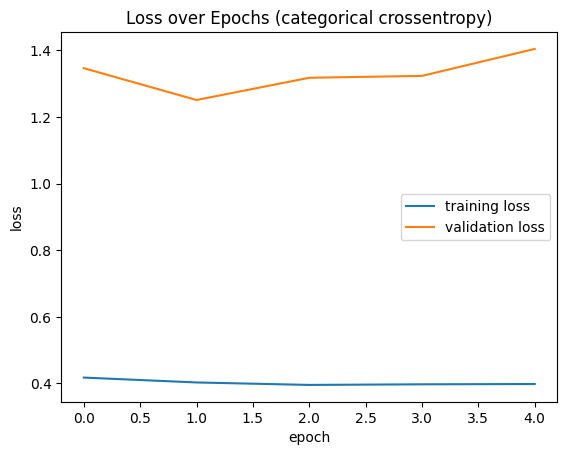

In [6]:
model.save("value network")

# plot the data
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

# label the axes
plt.xlabel("epoch")
plt.ylabel("loss")

plt.title("Loss over Epochs (categorical crossentropy)")
plt.legend(["training loss", "validation loss"])
plt.show()